In [1]:
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn import datasets
import numpy as np
import pandas as pd

In [2]:
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

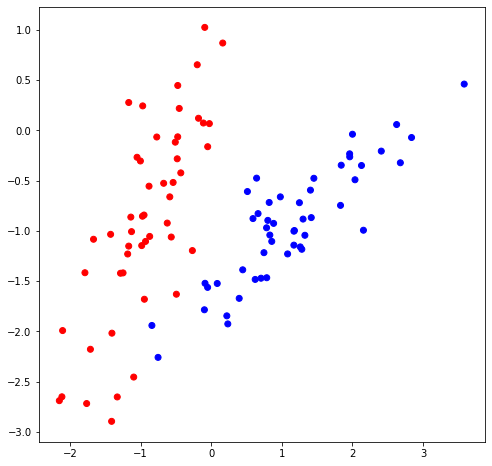

In [3]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [4]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [5]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [6]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [7]:
def gini(labels):#Джини
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [8]:
def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [9]:
def split(data, labels, index, t):# Разбиение датасета в узле
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [10]:
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [11]:
def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [12]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [13]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [14]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [15]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

## Задание 1
В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).

Напишем функцию build_tree с ограничением на глубину дерева. build_tree_limit

In [16]:
def build_tree_limit(data, labels,limit):
    limit-=1
    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or limit == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_limit(true_data, true_labels,limit)
    false_branch = build_tree_limit(false_data, false_labels,limit)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [17]:
my_tree_limit = build_tree_limit(train_data, train_labels,2)

In [18]:
my_tree = build_tree(train_data, train_labels)

In [19]:
# подсчитаем максимальную глубину дерева
def depth_tree(node,n=1):

    # Если лист, то выводим глубину долиста
    if isinstance(node, Leaf):   
        return n
    
    # Рекурсионный вызов функции на положительном поддереве
    l = depth_tree(node.true_branch, n=n+1)

    # Рекурсионный вызов функции на положительном поддереве
    m =  depth_tree(node.false_branch, n=n+1)
    return l,m

In [20]:
a,b = depth_tree(my_tree_limit)
a,b

(2, 2)

In [21]:
a,b = depth_tree(my_tree)
a,b

(((4, 4), 3), 2)

In [22]:
# Изучим качество  ответов для обучающей и тестовой выборки по дереву без ограничения
train_answers = predict(train_data, my_tree)
answers = predict(test_data, my_tree)
train_accuracy = tr_nolimit_dgini =accuracy_metric(train_labels, train_answers)
test_accuracy = test_nolimit_dgini=accuracy_metric(test_labels, answers)
train_accuracy, test_accuracy

(98.57142857142858, 100.0)

In [23]:
# Изучим качество  ответов для обучающей и тестовой выборки по дереву с ограничением
train_answers = predict(train_data, my_tree_limit)
answers = predict(test_data, my_tree_limit)
train_accuracy = tr_limit_dgini=accuracy_metric(train_labels, train_answers)
test_accuracy = test_limit_dgini =accuracy_metric(test_labels, answers)
train_accuracy, test_accuracy

(92.85714285714286, 96.66666666666667)

Как видно качество ответов в выборке лучше у дерева без ограничениея глубины

## Задание 2. 
Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

In [24]:
# Расчет критерия Энтропии

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p *np.log2(p)
        
    return impurity

In [25]:
# Расчет качества добавим аргумент, тип оценки

def quality(left_labels, right_labels, current_quality):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return current_quality - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [26]:
# Изучим качество  ответов для обучающей и тестовой выборки по дереву без ограничения c оценкой энтропия
train_answers = predict(train_data, my_tree)
answers = predict(test_data, my_tree)
train_accuracy = tr_nolimit_entropy=accuracy_metric(train_labels, train_answers)
test_accuracy =test_nolimit_entropy= accuracy_metric(test_labels, answers)
train_accuracy, test_accuracy

(98.57142857142858, 100.0)

In [27]:
my_tree_limit = build_tree_limit(train_data, train_labels,2)

In [28]:
# Изучим качество  ответов для обучающей и тестовой выборки по дереву с ограничением по критерю энтропия
train_answers = predict(train_data, my_tree_limit)
answers = predict(test_data, my_tree_limit)
train_accuracy = tr_limit_entropy = accuracy_metric(train_labels, train_answers)
test_accuracy = test_limit_entropy = accuracy_metric(test_labels, answers)
train_accuracy, test_accuracy

(92.85714285714286, 96.66666666666667)

In [29]:
result_test = np.array([['критерий','Без ограничений','С ограничением'],['Джини',test_nolimit_dgini,test_limit_dgini],
                        ['Энтропия',test_nolimit_entropy,test_limit_entropy]])
df=pd.DataFrame(result_test)
df

,0,1,2
0,критерий,Без ограничений,С ограничением
1,Джини,100.0,96.66666666666667
2,Энтропия,100.0,96.66666666666667


In [30]:
result_train = np.array([['критерий','Без ограничений','С ограничением'],['Джини',tr_nolimit_dgini,tr_limit_dgini],
                        ['Энтропия',tr_nolimit_entropy,tr_limit_entropy]])
df1=pd.DataFrame(result_train)
df1

,0,1,2
0,критерий,Без ограничений,С ограничением
1,Джини,98.57142857142858,92.85714285714286
2,Энтропия,98.57142857142858,92.85714285714286


Энтропия дает такие же результаты на тесте, как джини с ограничениме глубины дерева, при этом в энтропии уменьшение глубины не влияет на результат

## Задание 3 [опция].
Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [31]:
data, target, coef = datasets.make_regression(n_samples=1000, n_features = 1, n_informative = 1, 
                                                 n_targets = 1, noise = 20, coef = True, random_state = 3)

In [32]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(data, 
                                                                                     target, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

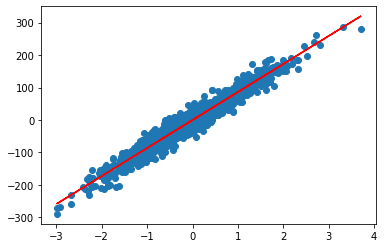

In [33]:
plt.scatter(data,target)
plt.plot(data,coef*data,color = 'red')
plt.show()

In [34]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = labels.mean()
    def predict(self):
        prediction = np.mean(self.labels)        
        return prediction

In [35]:
# Коэф детерминации
def R2(y_pred,y):
    return 1- ((y_pred - y)**2).sum()/((y-y.mean())**2).sum()

In [36]:
my_tree = build_tree(train_data, train_labels)

In [37]:
depth_tree(my_tree)

(2,
 ((4, (5, (6, 6))),
  ((5,
    (6,
     ((8, (9, (10, (11, 11)))),
      ((9, (10, 10)),
       ((((12, 12),
          (12,
           (((15, 15), (15, (16, (17, (18, 18))))),
            ((15, 15),
             (15,
              ((17, 17),
               ((18, (19, (20, 20))),
                (((20, (21, 21)), 19),
                 (19,
                  (20,
                   (((((25, (26, 26)),
                       ((26, 26),
                        (((28, (29, 29)), 27),
                         ((28, 28),
                          (((30, (31, 31)), 29),
                           (29,
                            ((31, 31),
                             ((((34, (35, 35)),
                                (34,
                                 (35,
                                  (36,
                                   ((38, (39, 39)),
                                    ((39, (40, (41, 41))), 38)))))),
                               32),
                              (32, (3

In [38]:
# Изучим качество  ответов для обучающей и тестовой выборки по дереву без ограничения
train_answers = predict(train_data, my_tree)
answers = predict(test_data, my_tree)
train_accuracy = tr_nolimit_dgini =R2(train_answers,train_labels)
test_accuracy = test_nolimit_dgini=R2(answers,test_labels)
train_accuracy,test_accuracy

(0.9554870193970023, 0.9339826541415054)

In [39]:
# Создадим функцию с лимитом дерева
def build_tree_limit(data, labels,limit):
    limit-=1
    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or limit == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_limit(true_data, true_labels,limit)
    false_branch = build_tree_limit(false_data, false_labels,limit)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [40]:
for i in range(2,100,5):
    my_tree_limit = build_tree_limit(train_data, train_labels,i)
    train_answers = predict(train_data, my_tree_limit)
    answers = predict(test_data, my_tree_limit)
    train_accuracy1 = tr_limit_dgini=R2(train_answers,train_labels )
    test_accuracy1 = test_limit_dgini =R2(answers,test_labels )
    print (f'Дерево c ограниченим на {i} . Качество на обучаеющей выборке {round(train_accuracy1,5)}, качество на тесовой выборке {round(test_accuracy1,5)}')
    if train_accuracy == train_accuracy1 and test_accuracy==test_accuracy1 :
        break

Дерево c ограниченим на 2 . Качество на обучаеющей выборке 0.06847, качество на тесовой выборке 0.05099
Дерево c ограниченим на 7 . Качество на обучаеющей выборке 0.52276, качество на тесовой выборке 0.50771
Дерево c ограниченим на 12 . Качество на обучаеющей выборке 0.71631, качество на тесовой выборке 0.72596
Дерево c ограниченим на 17 . Качество на обучаеющей выборке 0.84055, качество на тесовой выборке 0.82355
Дерево c ограниченим на 22 . Качество на обучаеющей выборке 0.90393, качество на тесовой выборке 0.89194
Дерево c ограниченим на 27 . Качество на обучаеющей выборке 0.94007, качество на тесовой выборке 0.92574
Дерево c ограниченим на 32 . Качество на обучаеющей выборке 0.9514, качество на тесовой выборке 0.93298
Дерево c ограниченим на 37 . Качество на обучаеющей выборке 0.95508, качество на тесовой выборке 0.93414
Дерево c ограниченим на 42 . Качество на обучаеющей выборке 0.95549, качество на тесовой выборке 0.93398
